### ResNet

##### Import relevant libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import time
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


##### Load data and visualize

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


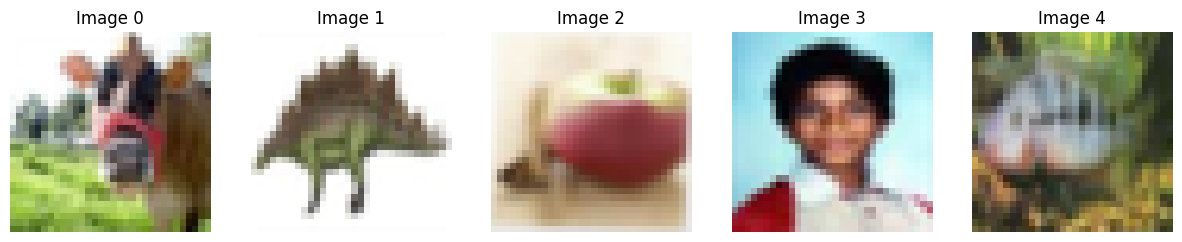

In [ ]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode="coarse")
    print(f"Training images shape: {train_images.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Testing images shape: {test_images.shape}")
    print(f"Testing labels shape: {test_labels.shape}")
    return train_images, train_labels, test_images, test_labels
train_images, train_labels, test_images, test_labels =load_data()


image_indices_to_visualize = [0, 1, 2, 3, 4]

plt.figure(figsize=(15, 3))
for i, image_index in enumerate(image_indices_to_visualize, 1):
    plt.subplot(1, 5, i)
    image = train_images[image_index, :, :, :]
    plt.imshow(image)
    plt.title(f"Image {image_index}")
    plt.axis('off')  # Turn off axis labels for clarity

plt.show()

##### Data pre-processing and augementation

In [ ]:
def pre_process(train_images, train_labels, test_images, test_labels):
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    #Convert labels to one hot coded suitable to ease calculation of categorical crossentropy Loss
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    return train_images, train_labels, test_images, test_labels

def data_stream(data,label):

    # Split the data into training and validation sets
    train_data, validation_data, train_label, validation_label = train_test_split(
        data, label, test_size=0.2, random_state=42
    )


    datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False
            )

    datagen.fit(train_data)
    # Create data generators for training and validation
    train_data_gen = datagen.flow(train_data, train_label, batch_size=40)
    validation_data_gen = datagen.flow(validation_data, validation_label, batch_size=40)


    return train_data_gen,validation_data_gen

    return data_gen


##### Define model

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    """Residual block for a simplified ResNet-like architecture."""
    f1, f2 = filters

    x_shortcut = x

    x = Conv2D(f1, (kernel_size, kernel_size), strides=(stride, stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(f2, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    # Shortcut connection
    x_shortcut = Conv2D(f2, (1, 1), strides=(stride, stride), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def resnet_model():
    input_shape = (32, 32, 3)
    num_classes = 20  # Adjust based on your task

    input_tensor = Input(shape=input_shape)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=input_shape)(input_tensor)
    x = Dropout(0.25)(x)

    x = residual_block(x, [128, 128], kernel_size=3, stride=1)
    x = residual_block(x, [256, 256], kernel_size=3, stride=2)
    x = residual_block(x, [256, 256], kernel_size=3, stride=1)

    x = residual_block(x, [512, 512], kernel_size=3, stride=1)
    x = residual_block(x, [512, 512], kernel_size=3, stride=2)
    x = residual_block(x, [512, 512], kernel_size=3, stride=1)

    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


##### Train model

In [ ]:
x_train_samples = 50000
x_test_samples = 10000
train_images, train_labels, test_images, test_labels=load_data()
train_images, train_labels, test_images, test_labels = pre_process(train_images[0:x_train_samples], train_labels[0:x_train_samples], test_images[0:x_test_samples], test_labels[0:x_test_samples])
rounded_labels=np.argmax(test_labels, axis=1)



model = resnet_model()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights = True)
start_time = time.time()
train_data_gen,validation_data_gen=data_stream(train_images,train_labels)
history = model.fit(train_data_gen,
                       steps_per_epoch=None,
                       epochs=20,
                       validation_data=validation_data_gen,
                       validation_steps=None,
                       verbose=1,
                      #  callbacks=[early_stop]
                       )
training_time = time.time() - start_time

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)
Epoch 1/20
1000/1000 [==============================] - 150s 141ms/step - loss: 2.6263 - accuracy: 0.1794 - val_loss: 2.6177 - val_accuracy: 0.2104
Epoch 2/20
1000/1000 [==============================] - 141s 141ms/step - loss: 2.3658 - accuracy: 0.2575 - val_loss: 2.2901 - val_accuracy: 0.2784
Epoch 3/20
1000/1000 [==============================] - 141s 141ms/step - loss: 2.1704 - accuracy: 0.3186 - val_loss: 2.2743 - val_accuracy: 0.3065
Epoch 4/20
1000/1000 [==============================] - 142s 142ms/step - loss: 2.0001 - accuracy: 0.3658 - val_loss: 1.9817 - val_accuracy: 0.3784
Epoch 5/20
1000/1000 [==============================] - 143s 142ms/step - loss: 1.8516 - accuracy: 0.4132 - val_loss: 1.8398 - val_accuracy: 0.4123
Epoch 6/20
1000/1000 [==============================] - 142s 142ms/step - loss: 1.7235 - accuracy: 0.4519 - va

##### Predict Test Data

In [ ]:
start_time = time.time()
y_predicted = np.argmax(model.predict(test_images[0:x_test_samples]), axis=1)
inference_time = time.time() - start_time

313/313 [==============================] - 10s 27ms/step


##### Evaluation metrics - Confusion matrix, accuracy, validation graphs

Accuracy: 67.89%
Precision: 70.77%
Recall (Sensitivity): 67.89%
F1 Score: 68.18%
Training Time: 2844.56 seconds
Inference Time: 10.0576 seconds


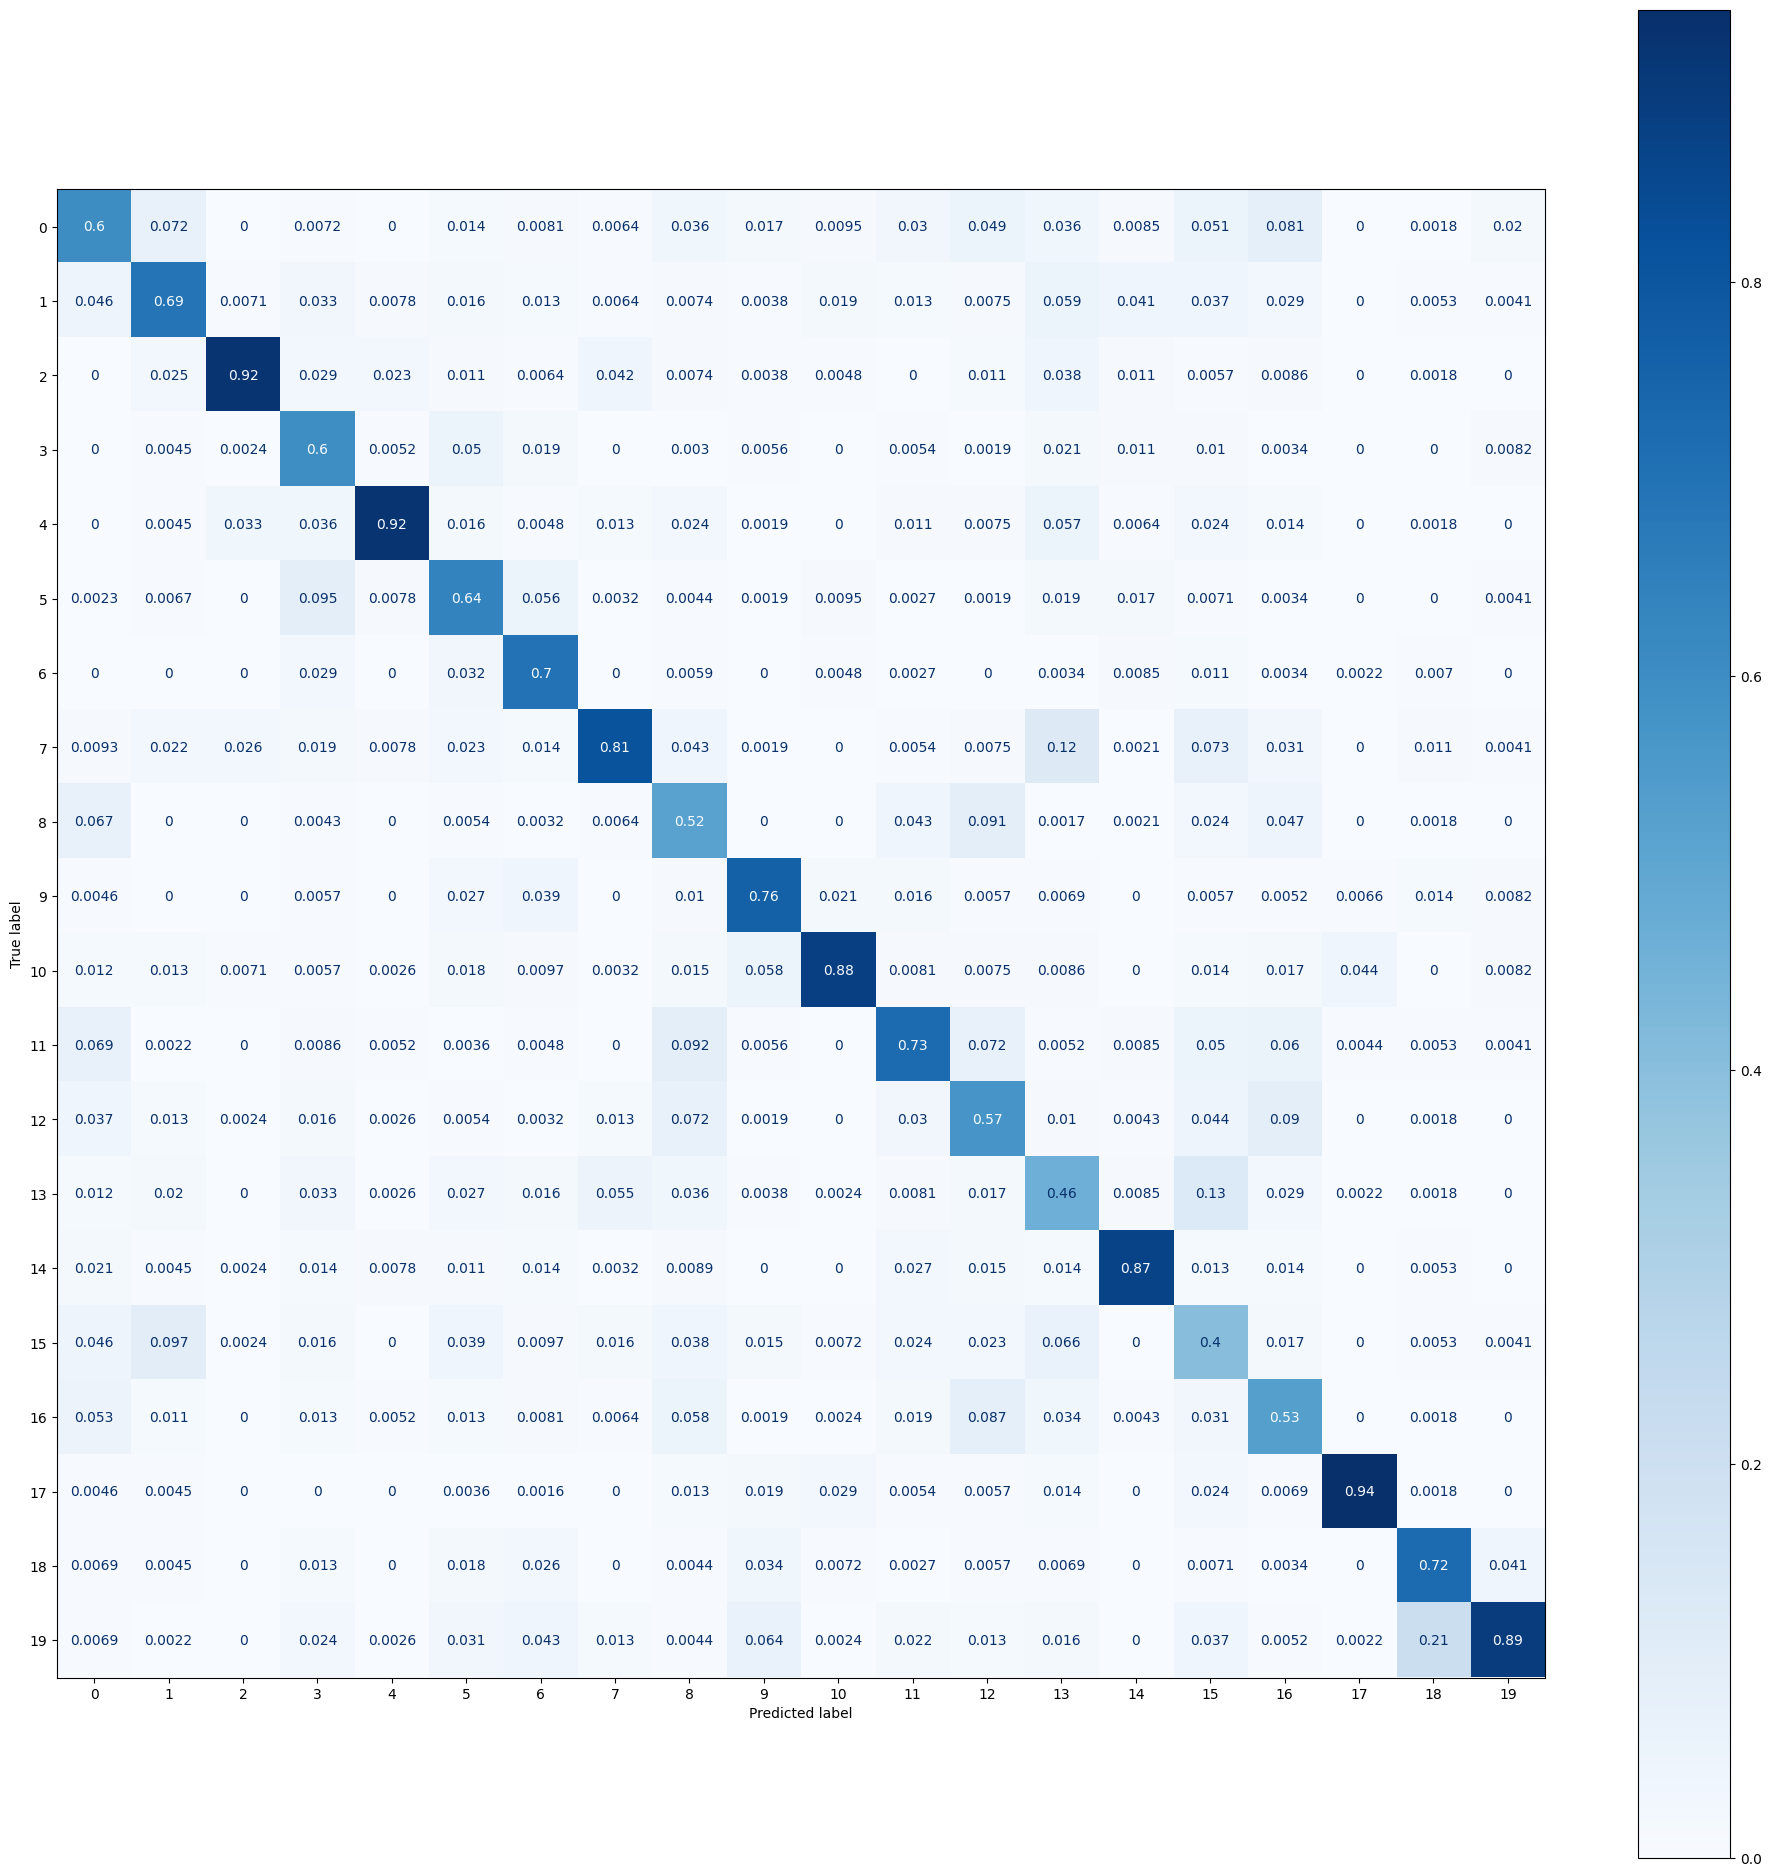

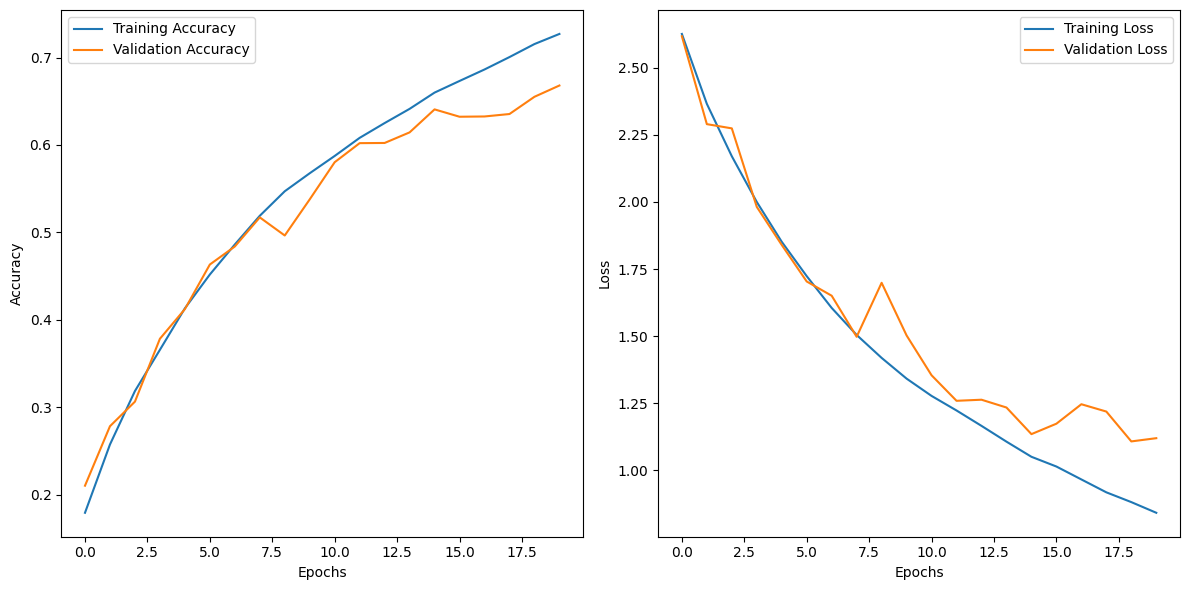

In [ ]:
def model_stats(history):
    plt.figure(figsize=(12, 6))
    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_conf_matrix(y1,y2):
    cm = confusion_matrix(y1, y2 , normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(24,24))
    disp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()

def print_metrics(y1,y2):
    # Accuracy
    accuracy = accuracy_score(y1, y2)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Precision
    precision = precision_score(y1, y2, average='macro', zero_division=1)
    print(f'Precision: {precision * 100:.2f}%')

    # Recall (Sensitivity)
    recall = recall_score(y1, y2, average='macro')
    print(f'Recall (Sensitivity): {recall * 100:.2f}%')

    # F1 Score
    f1 = f1_score(y1, y2, average='macro')
    print(f'F1 Score: {f1 * 100:.2f}%')


def print_time(training_time,inference_time):
   # Training Time
    print(f'Training Time: {training_time:.2f} seconds')

    # Inference Time
    print(f'Inference Time: {inference_time:.4f} seconds')

print_metrics(rounded_labels,y_predicted)
print_time(training_time,inference_time)
print_conf_matrix(rounded_labels,y_predicted)
model_stats(history)